# Solid Domestic Waste Classification Experimentation Notebook

- This notenook contains the pipelines and rutines that I designed in order to create the best possible classifier using classical preprocessing techniques and machine learning algorithms. 
- This notebook will only explain the functions designed in order to experiment and evaluate the models. The functions have been built to evaluate model performance over severall datasets, in order to determine the one that generates the best results.
- The image processing pipeline has been explained in demo_notebook.ipynb. I suggest you to recur first to this notebook in order to have a full understanding of the methods being used here.
- One of the main objectives of the project was to avoid using 'complex' models to perform the classification. So the main objective was to find the way of maximizing simple models performance.

# Imports

In [2]:
%%capture
# Import helper functions
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/image_processing.py

In [36]:
import os
import errno
# import shutil
# import zipfile
import timeit

# import cv2

import numpy as np
import pandas as pd
# import scipy
from random import sample
import matplotlib.pyplot as plt
# %matplotlib inline

from sklearn.decomposition import PCA, NMF

from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     train_test_split, learning_curve, 
                                     GridSearchCV)
from sklearn.metrics import (accuracy_score, plot_roc_curve, auc, 
                               confusion_matrix, roc_auc_score, roc_curve)

from sklearn.linear_model import LogisticRegression

from file_management import bring_data, walk_through_dir, storeresults, copytree
from image_processing import (load_images, get_visual_dictionary, get_histogram,
                              applypca, applynmf)
from evaluation_functions import (hyperparametertunning, learningcurve, 
                                  plotlearningcurve, CV)

import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Setting GPUs

In [6]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Num GPUs Available:  1
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.727390178999997
GPU (s):
0.04408741699995744
GPU speedup over CPU: 84x


# Manage files

In [7]:
path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
            '/content/drive/MyDrive/PI2/data/metal.zip']

# Unzip the data
bring_data(path_list=path_list)

# How many images/classes are there?
walk_through_dir("data")

Not found
There are 2 directories and 0 images in 'data'.
There are 0 directories and 403 images in 'data/cardboard'.
There are 0 directories and 410 images in 'data/metal'.


# Dimension Reduction

- This functions are used to perform differente dimensionality reduction techniques to multiple data sets obtained bellow.

In [26]:
def applypca(X):

    """
    Applies PCA to the dataset.

    Args:
        X: dataset

    Outputs:
        X_pca: pca dataset.
        pca: principal components analysis object.
    """

    pca = PCA()
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)

    return X_pca, pca

def applynmf(X, cont):

    """
    Applies NMF to the dataset.

    Args:
        X: dataset

    Outputs:
        X_nmf: nmf dataset.
        nmf: Non-negative Matrix Function object.
    """

    nmf = NMF(n_components = cont)
    X_nmf = nmf.fit_transform(X)
    X_nmf = pd.DataFrame(X_nmf)

    return (X_nmf,nmf)

# Run Preprocessing Functions

In [9]:
# Preprocessing
dims = (75, 75)
grayscale = True
blur = True
rescale = False
center = True
edges = False

# BoF
patch_size, step_size = 10,3

In [16]:
# Load images
image_dict = load_images(resize = dims, grayscale = grayscale, blur =  blur, 
                         rescale = rescale, center = center, edges = edges)
image_list = []
labels = []
for key, value in image_dict.items():
    image_list.extend(value)
    cat = [key]*len(value)
    labels.append(cat)

# Balancing dataset randomly
n = 403
cont = 0
balanced_image_list = []
balanced_label_list = []
for values in image_dict.values():
    images = sample(values, n)
    balanced_image_list.extend(images)
    label = [cont]*n
    balanced_label_list.extend(label)
    cont += 1

# Flattening
X = []

for img in balanced_image_list:
    dims = img.shape
    image = np.reshape(img, (1, dims[0]*dims[1]))[0]
    X.append(image)

X = pd.DataFrame(X)
y = pd.DataFrame(balanced_label_list)

# Bag of Features


In [17]:
# Bag of Features
vdict = get_visual_dictionary(balanced_image_list, patch_size, step_size, 60)
Xh = [get_histogram(img, patch_size, step_size, vdict) \
      for img in balanced_image_list]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

# Print First n images

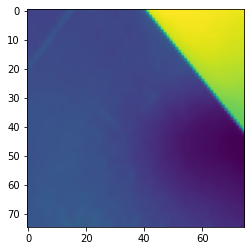

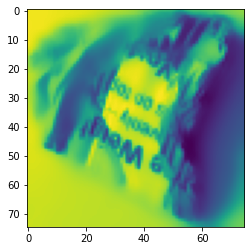

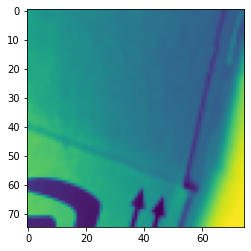

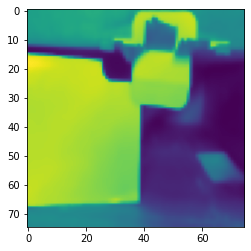

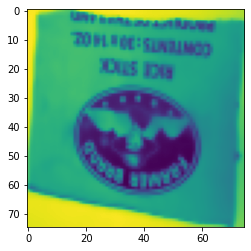

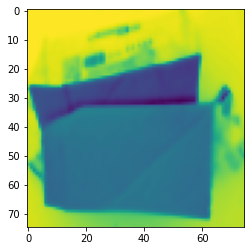

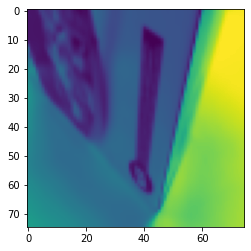

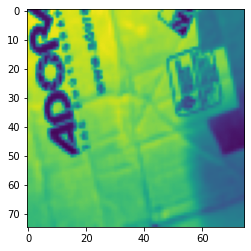

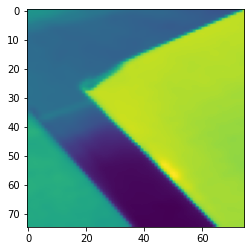

In [20]:
n = 10

for img in balanced_image_list[1:n]:
    plt.imshow(img)
    plt.show()

# Run Dimension Reduction

- Apply PCA and NMF dimensionality reduction to the both the pixel based and BoF based feature vectors. The PCA80 dataset indicates that only the larger principal components that sum up the 80% of the variance are taken into account. 

In [27]:
X_pca, pca = applypca(X)

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

X_pca80 = X_pca.iloc[:,:cont]

Xh_pca, pca = applypca(Xh) 

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

Xh_pca80 = Xh_pca.iloc[:,:cont]

X_nmf, nmf = applynmf(X, cont)
Xh_nmf, nmf = applynmf(Xh, cont)

print("Original X shape:",X.shape)
print("PCA Shape:",X_pca.shape)
print("PCA80 Shape",X_pca80.shape)
print("NMF Shape",X_nmf.shape,"\n")
print("Original BoF shape:",Xh.shape)
print("BoF PCA shape:",Xh_pca.shape)
print("BoF PCA80 shape",Xh_pca80.shape)
print("BoF NMF shape",Xh_nmf.shape)

Original X shape: (806, 5625)
PCA Shape: (806, 806)
PCA80 Shape (806, 29)
NMF Shape (806, 10) 

Original BoF shape: (806, 60)
BoF PCA shape: (806, 60)
BoF PCA80 shape (806, 10)
BoF NMF shape (806, 10)


# Model Evaluation

- From this part on the different functions of my evaluation rutine are specified.

# Learning Curve

- This functions are used to plot the learning curve. They are used in order to evaluate the model's learning. 
- Model fitting to data and learning rates are evaluated using the learning curves.
- The most common plots foun indicate us that the model is performing under fitting and that it is necessary to make adjustments to the data relations by feature engineering or to use a more complex model with higher abstraction abilities.



In [28]:
def plotlearningcurve(model_name, param_dict, param_title_dictionary, score, 
                      train_sizes_dict, train_scores_mean_dict, 
                      train_scores_std_dict, test_scores_mean_dict,
                      test_scores_std_dict, path):
  
    """ 
    To plot the learning curve.
    Args:
        model_name: model name (String).
        param_dict: model parameter grid (dictionary).
        param_title_dictionary: model hyperparameter title (String).
        score: ylabel. Metric with which the model is evaluated (String).
        train_sizes_dict: train_sizes for each dataset considered (dictionary).
        train_scores_mean_dict: mean of the training scores for each train size 
            (dictionary).
        train_scores_std_dict: self explanatory.
        test_scores_mean_dict: self explanatory.
        test_scores_std_dict: self explanatory.
        path: path to load the graphs.
    """
    
    # Loop for each dataset
    for dataset_key in train_sizes_dict:

        train_sizes = train_sizes_dict[dataset_key]
        train_scores_mean = train_scores_mean_dict[dataset_key]
        train_scores_std = train_scores_std_dict[dataset_key]
        test_scores_mean = test_scores_mean_dict[dataset_key]
        test_scores_std = test_scores_std_dict[dataset_key]

        # Experiment Title
        title = model_name + '_' + dataset_key + '_' + \
                                            param_title_dictionary[dataset_key]

        plt.figure()
        plt.title(title)
        plt.xlabel('Training examples')
        plt.ylabel(score)
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.1,
                            color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                            test_scores_mean + test_scores_std, alpha=0.1, 
                            color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                    label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                    label="Cross-validation score")
        plt.legend(loc="best")

        # Save Figure
        filename = 'learningcurve_'+ str(title) + '.jpg'
        plt.savefig(os.path.join(path,filename), dpi = 100)
        
        plt.show()

def learningcurve(classifier, X_dict, y, cv, param_dict, scoring, train_sizes):
    """ Calculate the learning curve values.
    Args:
        classifier: model used to perform the prediction
        X_dict: datasets dictionary
        y: labels
        cv: number of cross-validation splits
        param_dict: parameter dictionary
        scoring: metric used to evaluate cross validation
        train_sizes: specified train sizes
    Output:
        train_sizes_dict: train_sizes for each dataset considered (dictionary).
        train_scores_mean_dict: mean of the training scores for each train size 
            (dictionary).
        train_scores_std_dict: self explanatory.
        test_scores_mean_dict: self explanatory.
        test_scores_std_dict: self explanatory.
    """

    train_sizes_dict = {}
    train_scores_mean_dict = {}
    train_scores_std_dict = {}
    test_scores_mean_dict = {}
    test_scores_std_dict = {}

    for dataset_key in X_dict:

        X_train = X_dict[dataset_key]

        # Set Parameters
        classifier.set_params(**param_dict[dataset_key])

        train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                    X_train, y, 
                                    cv = cv, 
                                    scoring = scoring, 
                                    train_sizes = train_sizes)

        train_scores_mean = np.mean(train_scores, axis = 1)
        train_scores_std = np.std(train_scores, axis = 1)
        test_scores_mean = np.mean(test_scores, axis = 1)
        test_scores_std = np.std(test_scores, axis = 1)

        train_sizes_dict[dataset_key] = train_sizes
        train_scores_mean_dict[dataset_key] = train_scores_mean
        train_scores_std_dict[dataset_key] = train_scores_std
        test_scores_mean_dict[dataset_key] = test_scores_mean
        test_scores_std_dict[dataset_key] = test_scores_std

    return (train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
            test_scores_mean_dict, test_scores_std_dict)

# Cross Validation

- In here a k-fold CV ROC Curve is plotted. There exist a precision-recall version, however, as those metrics are not all that relevant during this study, we don't include them here.
- The recolection of the metrics of interest can be modified by changing them in the second function. 

In [29]:
def plotrocauc(auc_list, fpr, tpr, tprs, mean_auc, mean_fpr,
               mean_tpr, title, path, fig, ax):
    """
    Plot the ROC curve.
    Args:
        auc_list: list of auc values.
        fpr: false positive rate list.
        tpr: true positive rate list.
        mean_auc: value.
        mean_fpr: mean fpr list.
        mean_tpr: mean tpr list.
        title: model_name.
        path: to load the data.
    """

    # Plot ROC AUC Curves
    for i in range(len(fpr)):
        ax.plot(fpr[i], tpr[i], lw = 3, alpha = 0.5,
                label='ROC fold %d (area = %0.2f)' % (i, auc_list[i]))

    # Plot diagonal
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance',
            alpha=.8)

    # Plot Mean ROC AUC
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_list)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % 
            (mean_auc, std_auc),
            lw=2, alpha=1)
    
    # Plot Confidence Interval
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                    alpha=.2, label=r'$\pm$ 1 std. dev.')
    
    # Settings
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title='ROC Curve')
    ax.legend(loc="lower right")

    # Save Figure
    filename = 'pr_roc_' + str(title) + '.jpg'
    plt.savefig(os.path.join(path,filename), dpi = 100)

    plt.show()


def CV(classifier, X_dict, y , k, param_dict, param_title_dictionary, 
       model_name, path):

    """ 
    Calculate cross validation metrics and ROC curves.
    Args:
        classifier: model.
        X_dict: dataset dictionary.
        y: labels.
        k: number of splits.
        param_dict: parameter dictionary for the model.
        param_title_dictionary: model hyperparameter title (String).
        model_name: self explanatory.
        path: to load the data.
    Output:
        precision_dict: precision scores per experiment dictionary.
        recall_dict: recall scores per experiment dictionary.
        f1_dict: f1 scores per experiment dictionary.
        auc_dict: auc scores per experiment dictionary.
    """

    # Desired Metrics to include
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    auc_dict = {}


    # Creating Stratified Fold for integration with CV
    skf = StratifiedKFold(n_splits = k)

    for dataset_key in X_dict:

        fig, ax = plt.subplots(1,2,figsize = (20,10), dpi = 100)

        X = X_dict[dataset_key]

        # Set Parameters
        classifier.set_params(**param_dict[dataset_key])
        
        # Experiment Title
        title = model_name + '_' + dataset_key + '_' + \
                                            param_title_dictionary[dataset_key]

        fig.suptitle(title)

        # Desired Metrics to include
        precision_list = []
        recall_list = []
        f1_list = []
        auc_list = []

        # Necessary Lists
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        tprs = []

        # Positive Rates
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i, (train, test) in enumerate(skf.split(X,y)):

            # Separate in train and test samples
            X_train = X.iloc[train,:]
            y_train = y.iloc[train]
            X_test = X.iloc[test,:]
            y_test = y.iloc[test]

            # Fitting the model
            classifier.fit(X_train,y_train)

            # Predict
            y_pred = classifier.predict(X_test)

            # Find Desired Metrics and add it to list
            precision = precision_score(y_test,y_pred)
            precision_list.append(precision)
            recall = recall_score(y_test,y_pred)
            recall_list.append(recall)
            f1 = f1_score(y_test,y_pred)
            f1_list.append(f1)

            # Score function
            y_score = classifier.predict_proba(X_test)[:,1]

            # Average Precision
            average_precision = average_precision_score(y_test, y_score)

            # Plot Prediction-Recall Curve
            disp = plot_precision_recall_curve(classifier, X_test, y_test,
                                               ax = ax[0],
                                               label = 'PR Fold '+str(i)+\
                                               ' AP: {0:0.2f}'\
                                               .format(average_precision))
            ax[0].legend(loc = 'best')
            ax[0].set_title('Precision Recall Curve')

            # ROC AUC Curve
            fpr[i], tpr[i], thresholds = roc_curve(y_test,y_score)
            auc_list.append(auc(fpr[i],tpr[i]))
            aux = np.interp(mean_fpr, fpr[i], tpr[i])
            mean_tpr += aux
            mean_tpr[0] = 0.0
            tprs.append(aux)

        # Building Mean ROC AUC Curve
        mean_tpr /= k
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        plotrocauc(auc_list,fpr,tpr,tprs,mean_auc,mean_fpr,mean_tpr,title,path,
                   fig, ax = ax[1])

        # Add lists to dictionaries
        precision_dict[dataset_key] = precision_list
        recall_dict[dataset_key] = recall_list
        f1_dict[dataset_key] = f1_list
        auc_dict[dataset_key] = auc_list

    return precision_dict, recall_dict, f1_dict, auc_dict

# Managing results

- This functions are used to organize the results of the experiments and store them aproppriately in my drive. They allow me to run my experiments without worrying of manually inserting my results into different files.
- They help me automatize the compilation of the model's hyperparameters and the results in cross-validation for each dataset.

In [30]:
def storemodel(classifier, param_dict, dataset_key, X, y, path, model_name):

    """
    Stores a trained model (.joblib format) in the specified path.
    Args:
        classifier: used model to perform predictions.
        param_dict: models hyperparameter dictionary.
        dataset_key: dataset key.
        X: independent variables.
        y: dependent variable.
        path: path in which tje model is going to be stored.
        model_name: name of the model
    """ 

    # Set Parameters
    clf = classifier.set_params(**param_dict[dataset_key])

    # Train Model
    clf_fitted = clf.fit(X,y)

    # Save model
    joblib.dump(clf_fitted,path+'/'+model_name+'.joblib')


def storeresults(classifier, results, model_name, param_dict, 
                 param_title_dictionary, X, y, path):
    
    """ Creates a dataframe with tabulated results
    Args:
        classifier: used model to perform predictions.
        results: array of metric dictionaries.
        model_name: self explanatory.
        param_dict: models parameter grid.
        param_title_dictionary: model hyperparameter title (String).
        X: independent variables.
        y: dependent variables.
        path: path to load the model.
    Output: 
        df: Dataframe with results.
    """


    # Creating Dataframe that contains results
    df = pd.DataFrame({'Model':str,'Dataset':str,
                            'Mean_Precision':float,
                            'STD_Precision':float,
                            'Mean_Recall':float,
                            'STD_Recall':float,
                            'Mean_F1':float,
                            'STD_F1':float,
                            'Mean_AUC':float,
                            'STD_AUC':float},index = [0])

    for dataset_key in param_dict.keys():

        # Extract list
        precision = results[0][dataset_key]
        recall = results[1][dataset_key]
        f1 = results[2][dataset_key]
        auc = results[3][dataset_key]

        # Extract Statistic
        precision_mean = np.mean(precision)
        precision_std = np.std(precision)
        recall_mean = np.mean(recall)
        recall_std = np.std(recall)
        f1_mean = np.mean(f1)
        f1_std = np.std(f1)
        auc_mean = np.mean(auc)
        auc_std = np.std(auc)

        # Experiment model and hyperparameter
        name = model_name + '_' + param_title_dictionary[dataset_key]

        storemodel(classifier, param_dict, dataset_key, X, y, path, name)
        
        df = df.append({'Model':name,'Dataset':dataset_key,
                            'Mean_Precision':precision_mean,
                            'STD_Precision':precision_std,
                            'Mean_Recall':recall_mean,
                            'STD_Recall':recall_std,
                            'Mean_F1':f1_mean,
                            'STD_F1':f1_std,
                            'Mean_AUC':auc_mean,
                            'STD_AUC':auc_std},ignore_index=True)
        
    df.drop(index = 0, axis = 0, inplace = True)
        
    return df

def copytree(dir, src, dst, symlinks=False, ignore=None):
    """ 
    Used to copy a whole directory into a destination.
    Args:
        dir: name of the directory.
        src: source path.
        dst: destination path. 
    """

    dst = os.path.join(dst,dir)

    try:
        os.mkdir(dst)
    except OSError as e:
        if e.errno == errno.EEXIST:
            print('Directory already exist')
        else:
            raise

    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

# Hyperparameter Tuning

- It automatizes the process of hyper tuning the model over the different specified datasets.

In [31]:
def hyperparametertunning(classifier, X_dict, y, param_grid, k, scoring):

    """
    Tunes the hyperparameters of a given classifier using grid search.
    Args:
        classifier: model used to perform predictions.
        X_dict: dataset dictionary.
        y: dependent variable.
        param_grid: hyperparameter grid.
        k: number of folds for cross-validation.
        scoring: reference metric to evaluate tuning.
    Outputs:
        param_dict: models optimal hyperparameter grid.
        param_title_dictionary:
    """

    # Best Parameter dictionary
    param_dict = {}

    # Parameter title dictionary
    param_title_dictionary = {}

    # Specify CV
    skf = StratifiedKFold(n_splits = k)

    # Test each dataset
    for dataset_key in X_dict:

        X_train = X_dict[dataset_key]

        clf = GridSearchCV(classifier, param_grid, cv  = skf, scoring = scoring)
        clf.fit(X_train, y)

        # Store parameters
        param_dict[dataset_key] = clf.best_estimator_.get_params()

        hyperparameter_title = ''
        for hyperparameter in param_grid.keys():
            hyperparameter_title += hyperparameter + '=' + \
                        str(param_dict[dataset_key][hyperparameter]) + '-'

        # Store titles
        param_title_dictionary[dataset_key] = hyperparameter_title[:-1]

    return param_dict, param_title_dictionary

# Model

- Here is were the experimentation starts. A local directory is created in order to store the plots, csv, and text files compiling the results of each experiment. 
- As stated before, the directories will be copied into drive after being carried out.
- As it can be seen on the last line of the following cell, the model is tested using differen datasets.

In [34]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/sdw_classification/experiments/KNN'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'Regular':X,'PCA':X_pca,'PCA80':X_pca80,'NMF':X_nmf,'BoF':Xh,
          'BoF-PCA':Xh_pca,'BoF-PCA80':Xh_pca80,'BoF-NMF':Xh_nmf}

Type Experiment Name: Test
Type Model Name: Logistic_Regression


# Hyperparameter Tunning

In [37]:
%%capture

# Classifier
model = LogisticRegression()

# Create parameter grid
penalty = ['l1','l2','elasticnet','none']
C = np.logspace(0,4,10)
hyperparameters = dict(C = C,penalty = penalty)

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'f1')

# Learning Curve

In [38]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y, 
                                        5, param_dict, 'f1', 
                                        np.linspace(0.1,1,50))

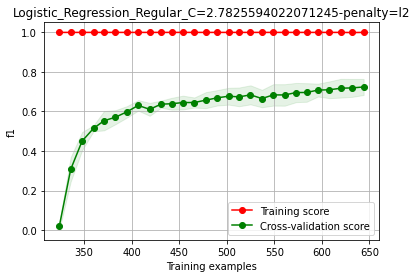

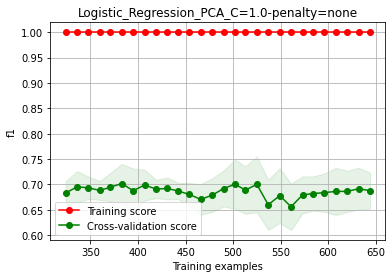

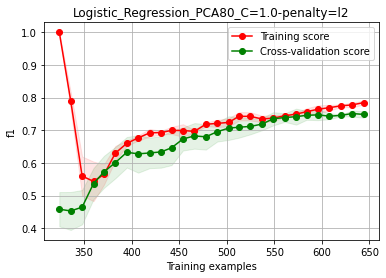

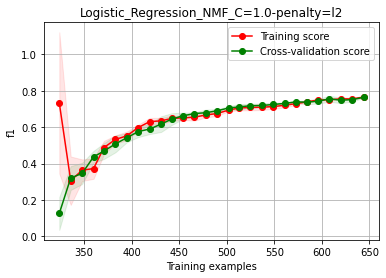

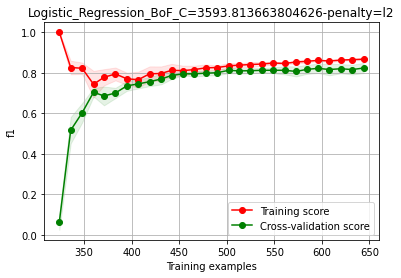

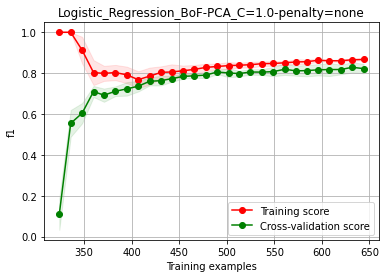

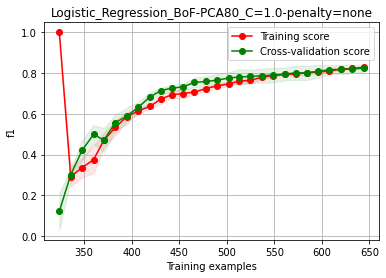

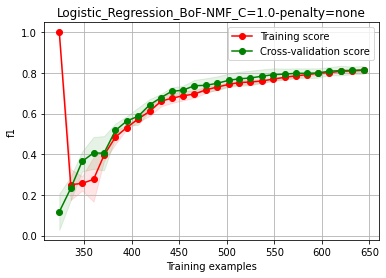

In [39]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'f1', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

# Cross Validation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

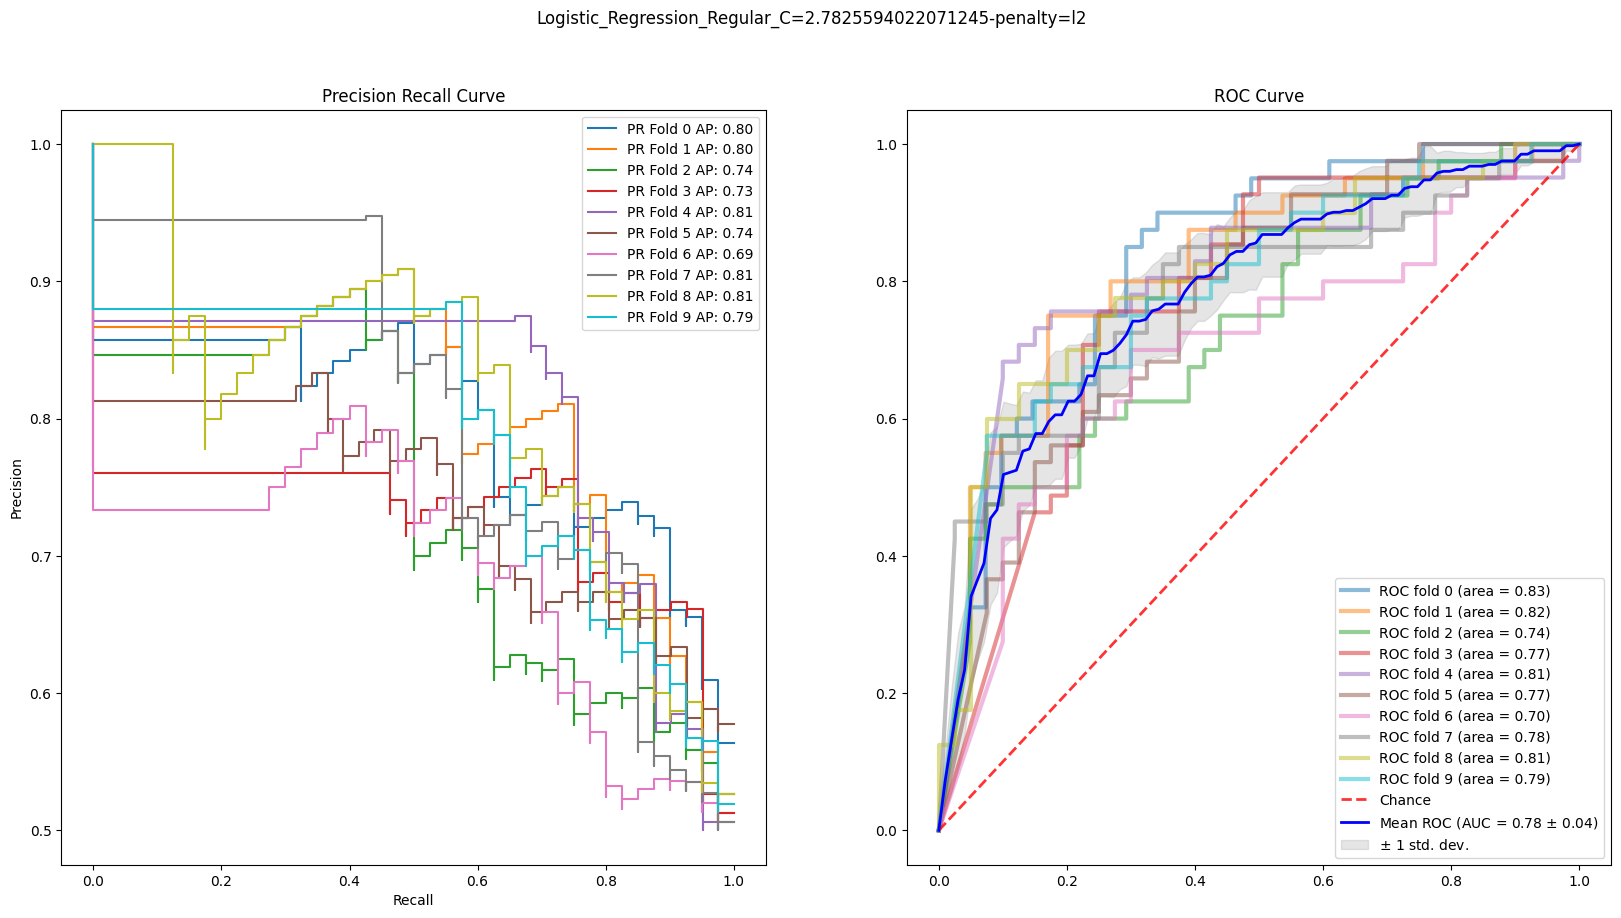

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

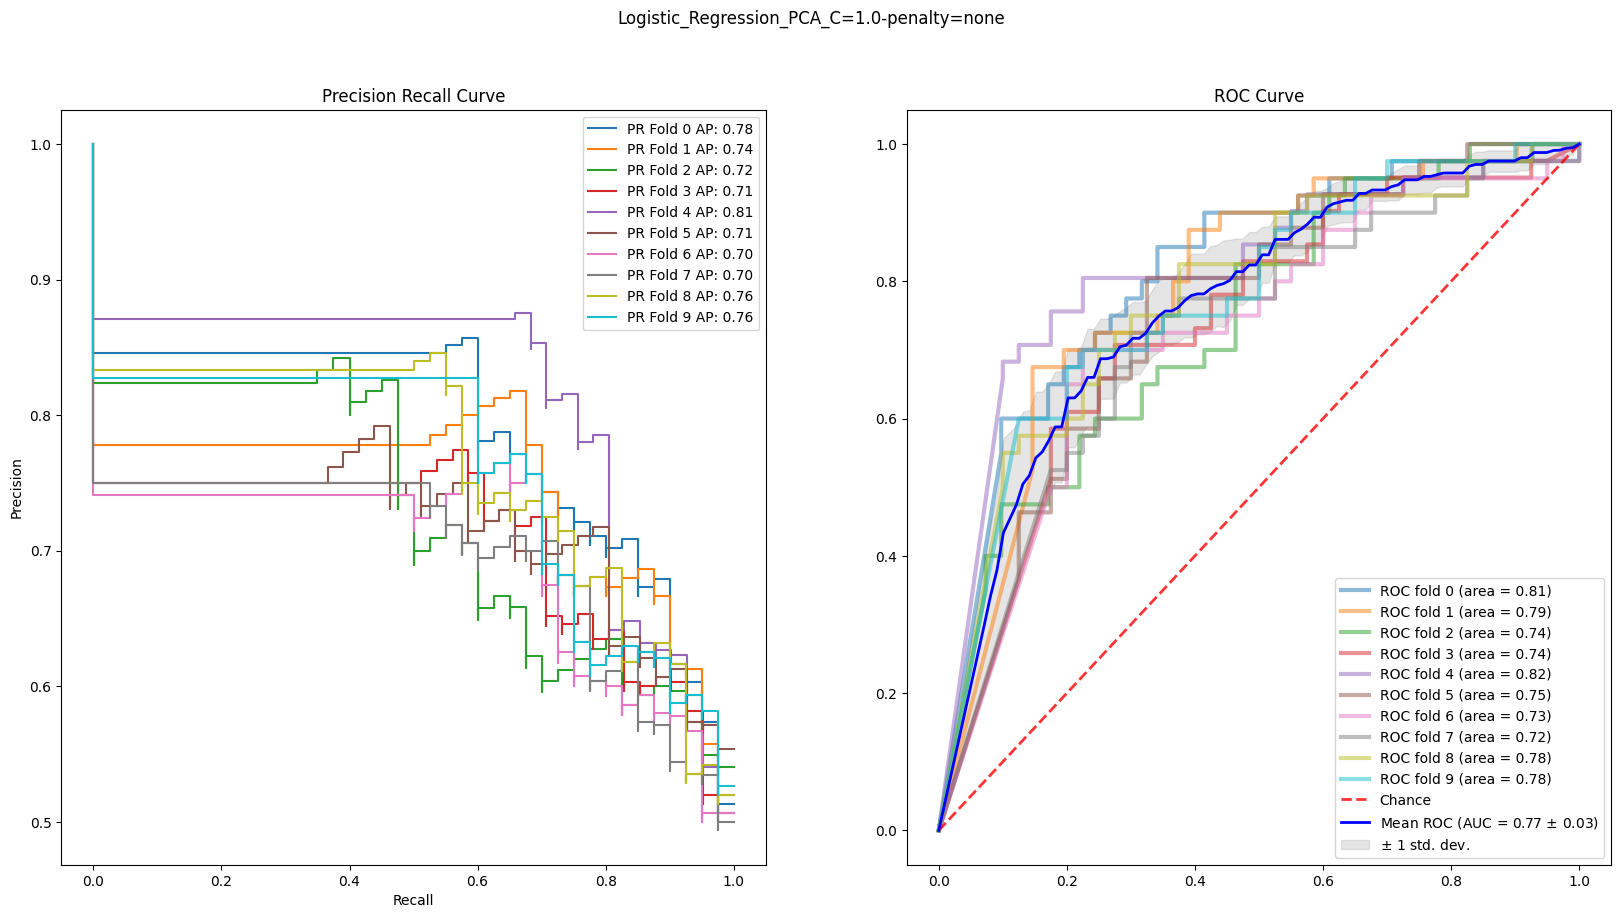

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

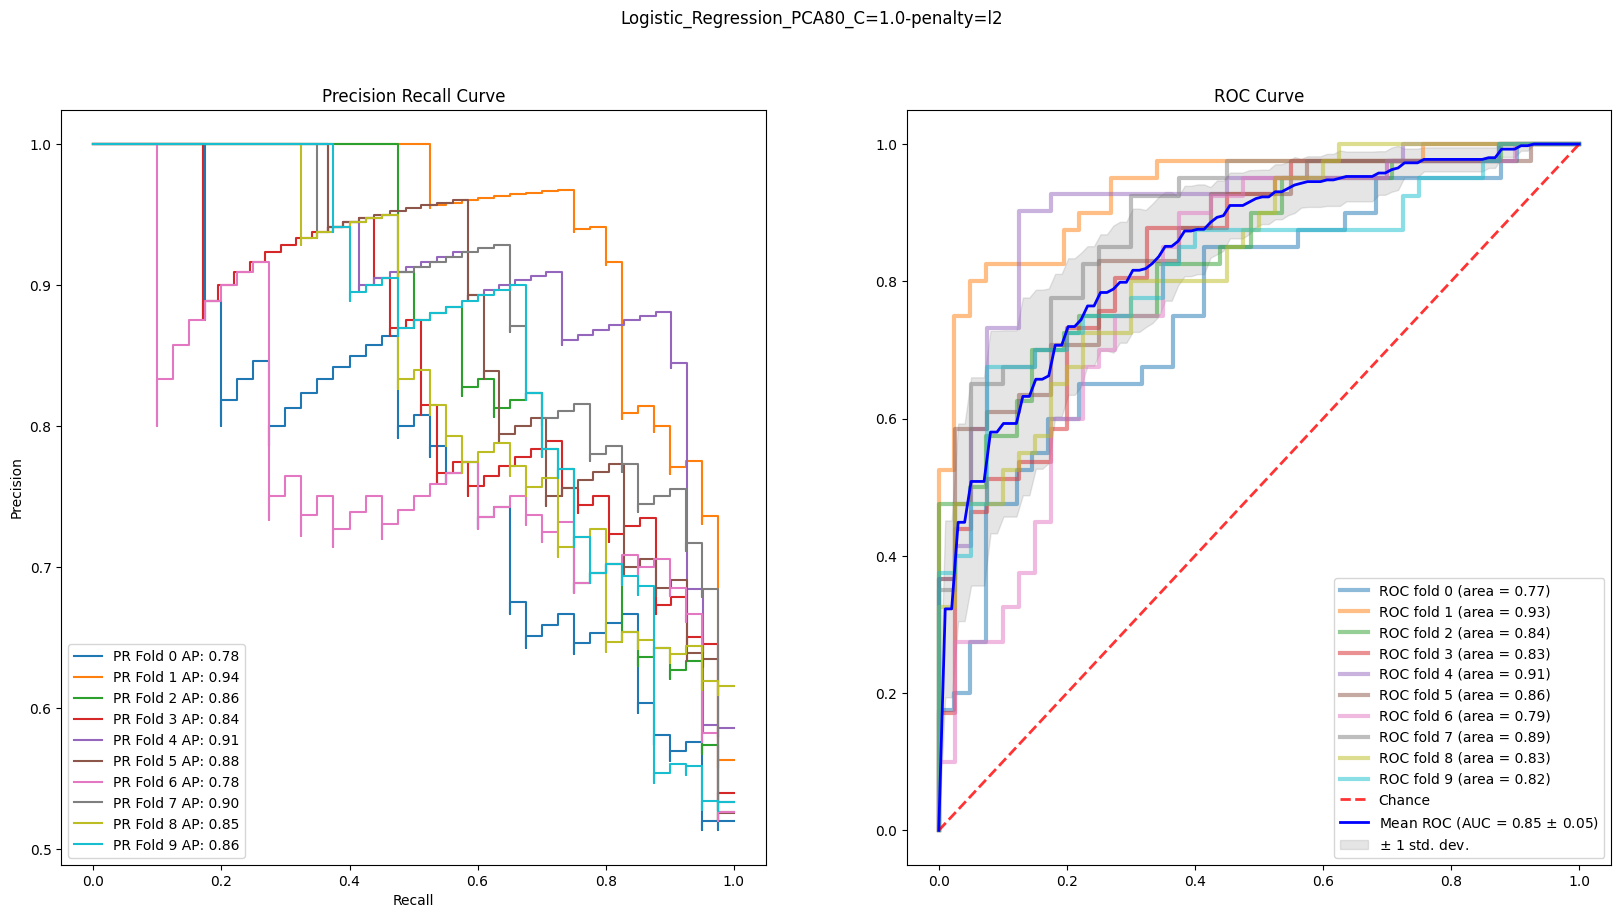

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

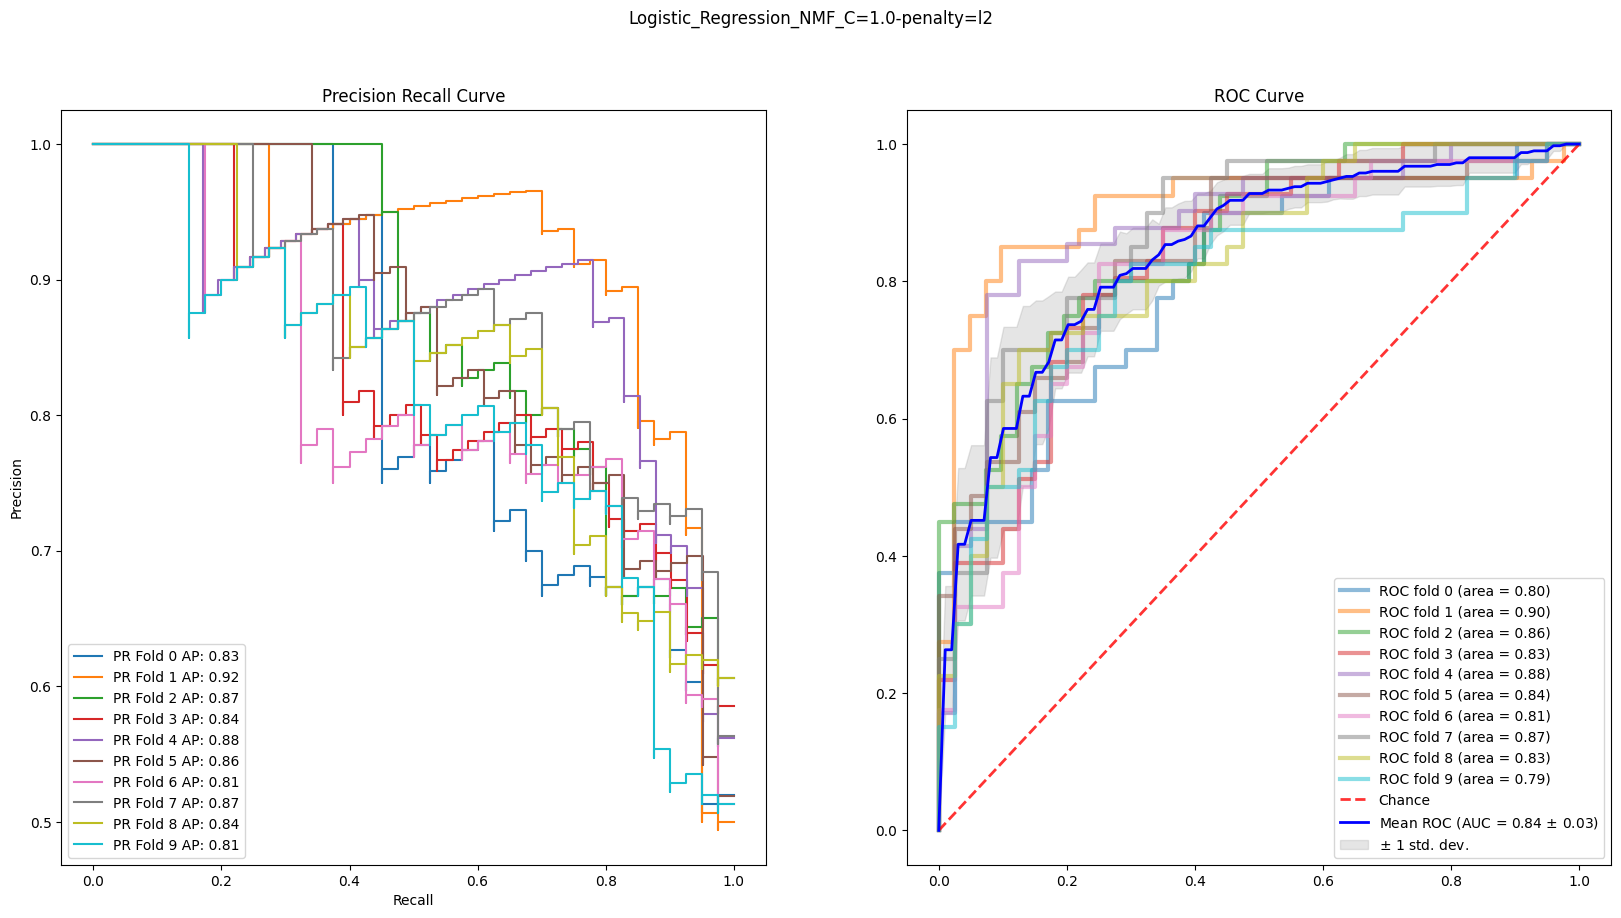

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

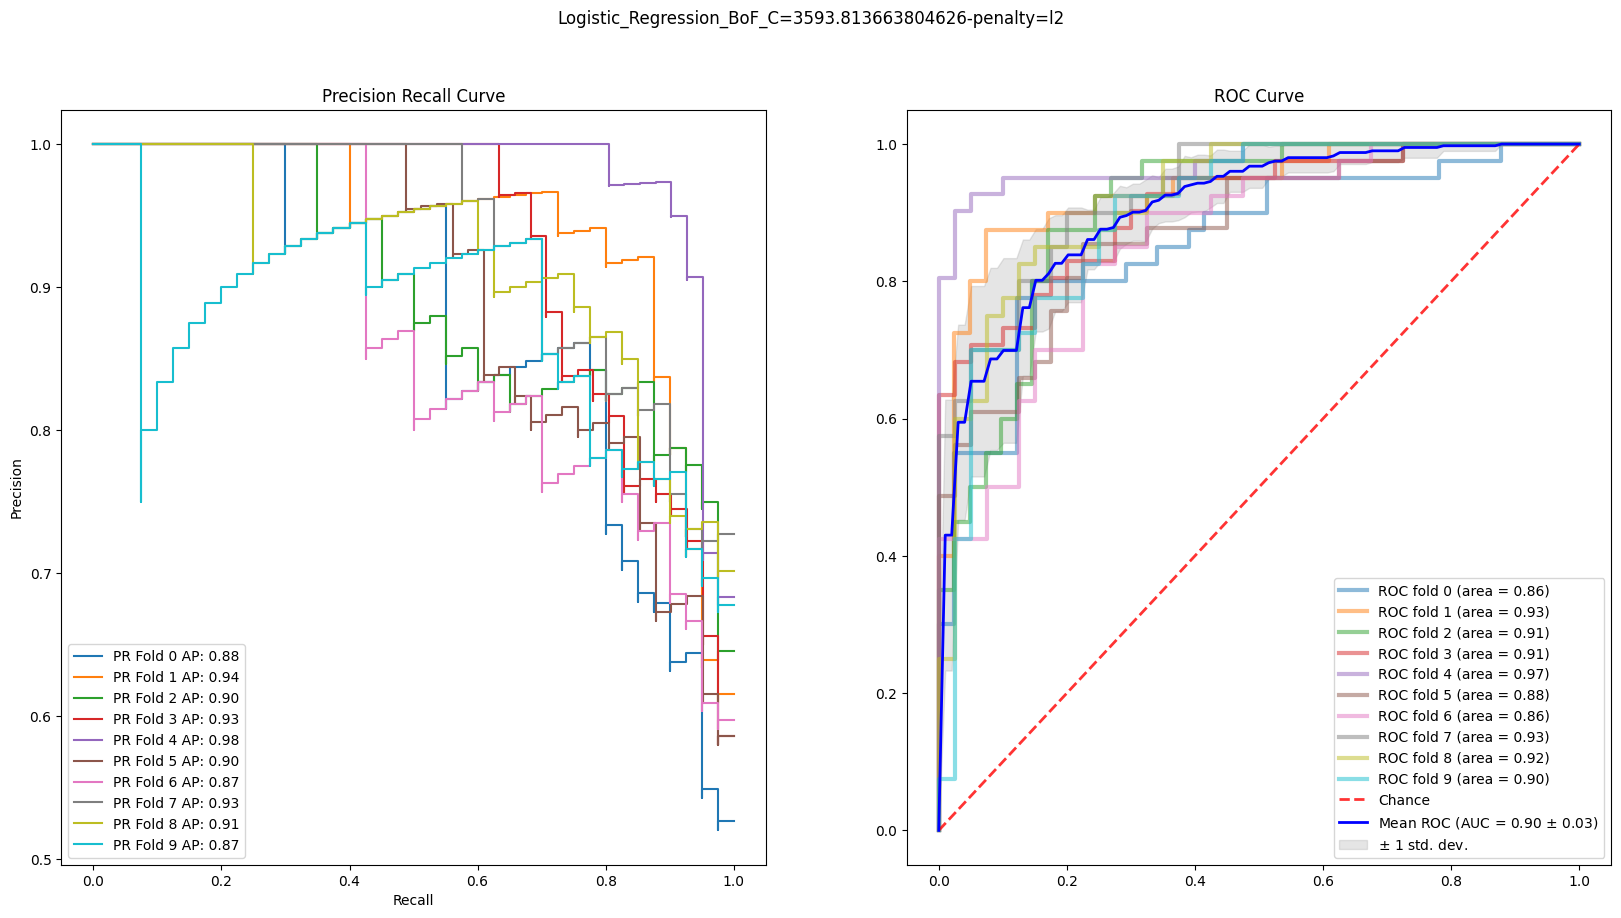

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

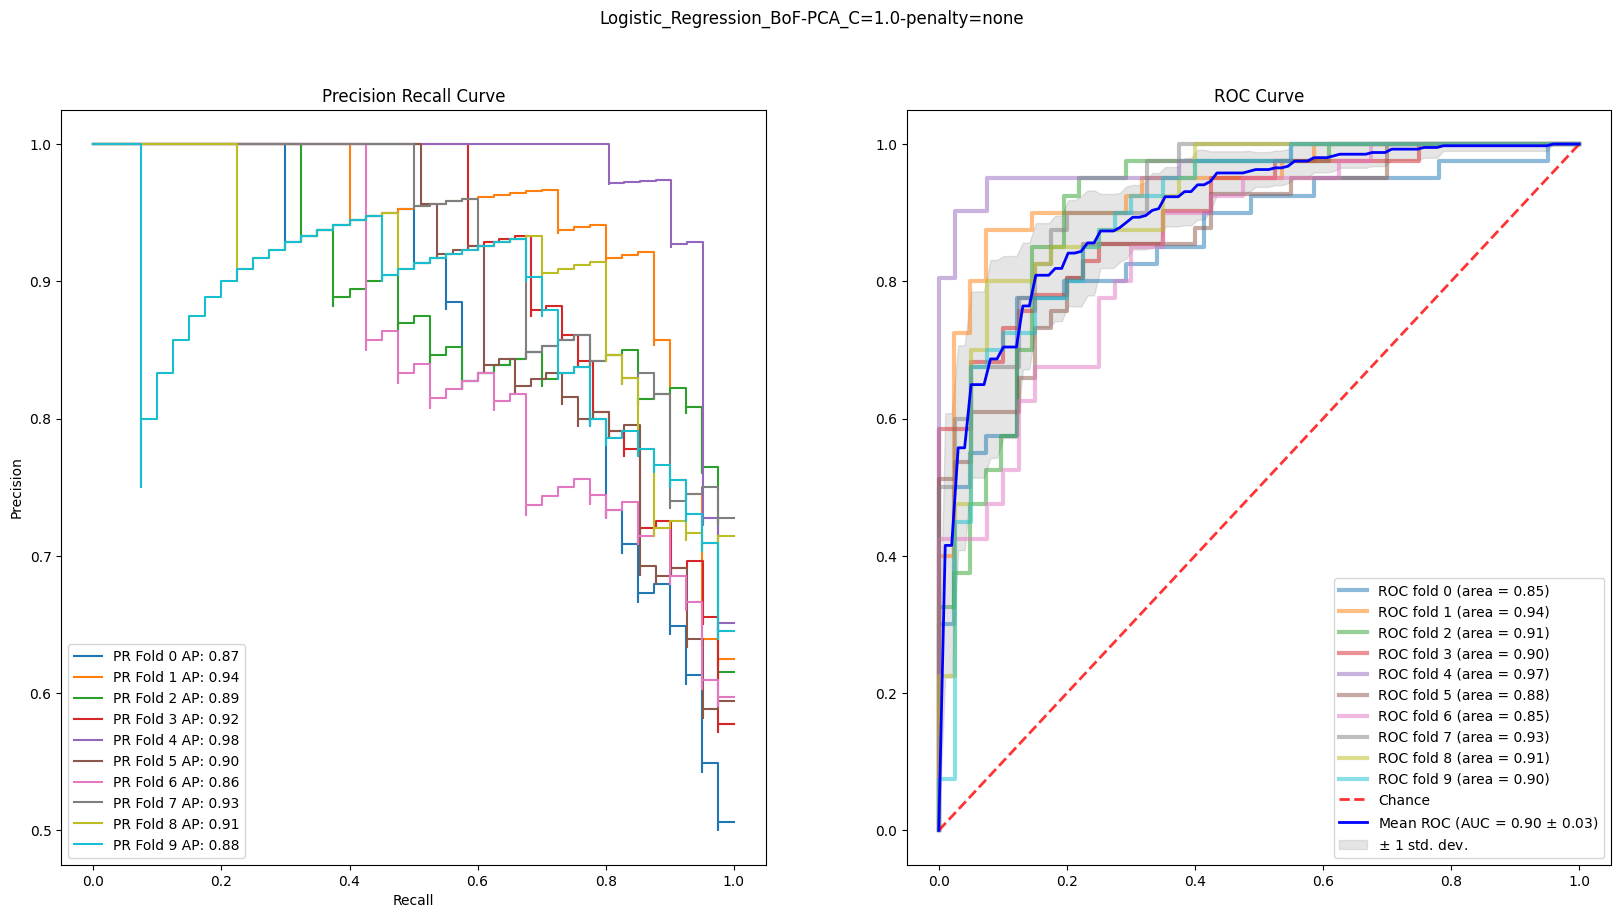

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

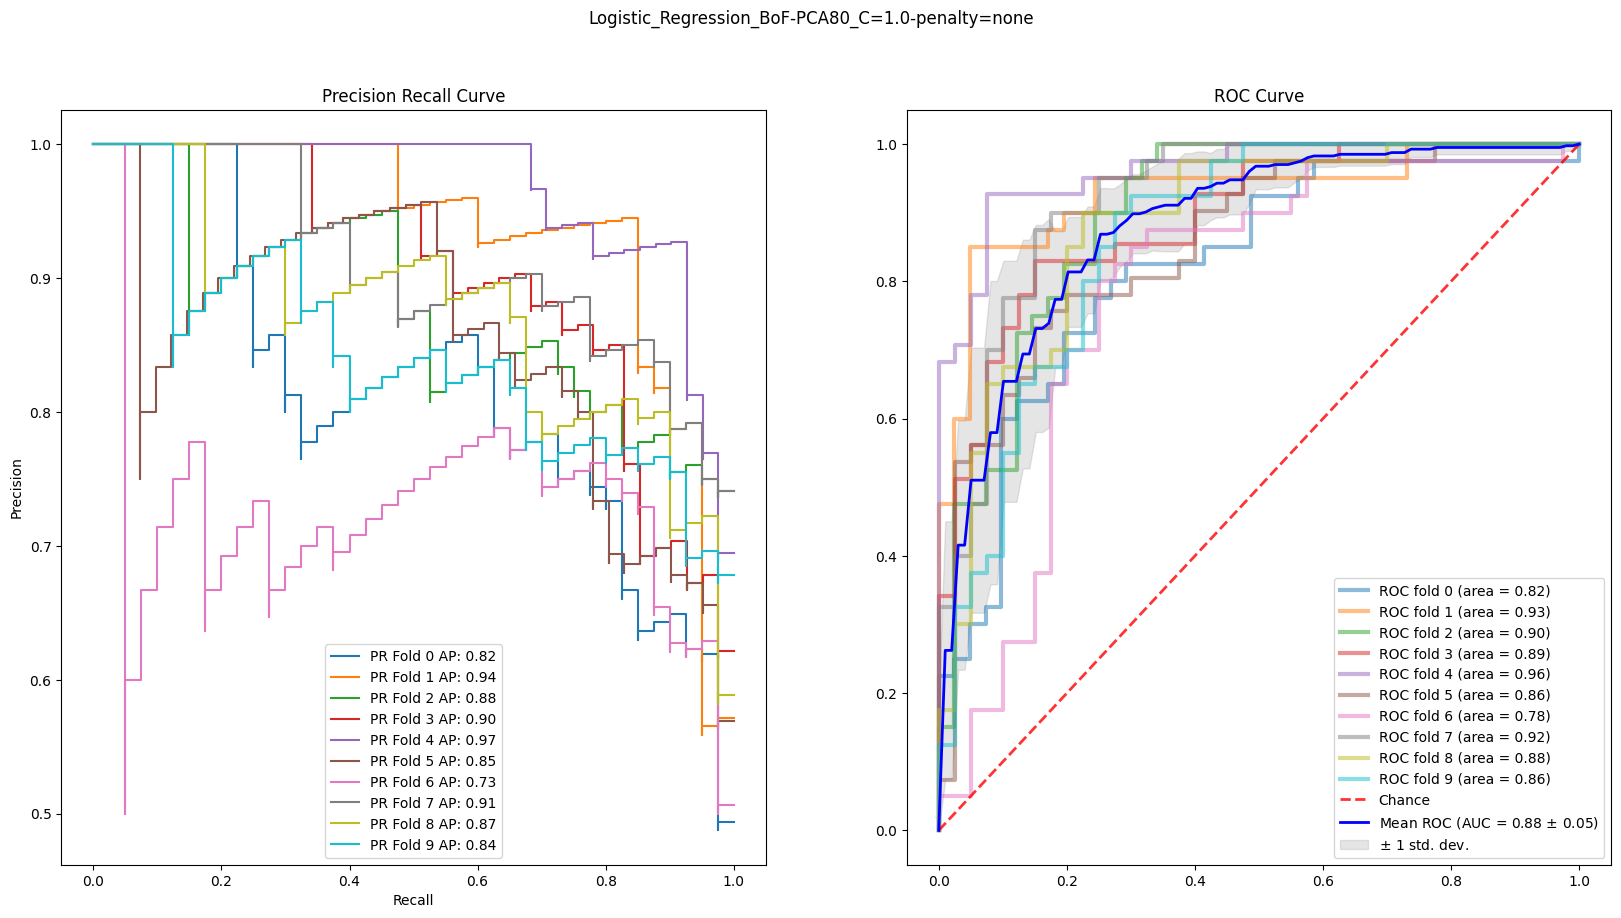

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

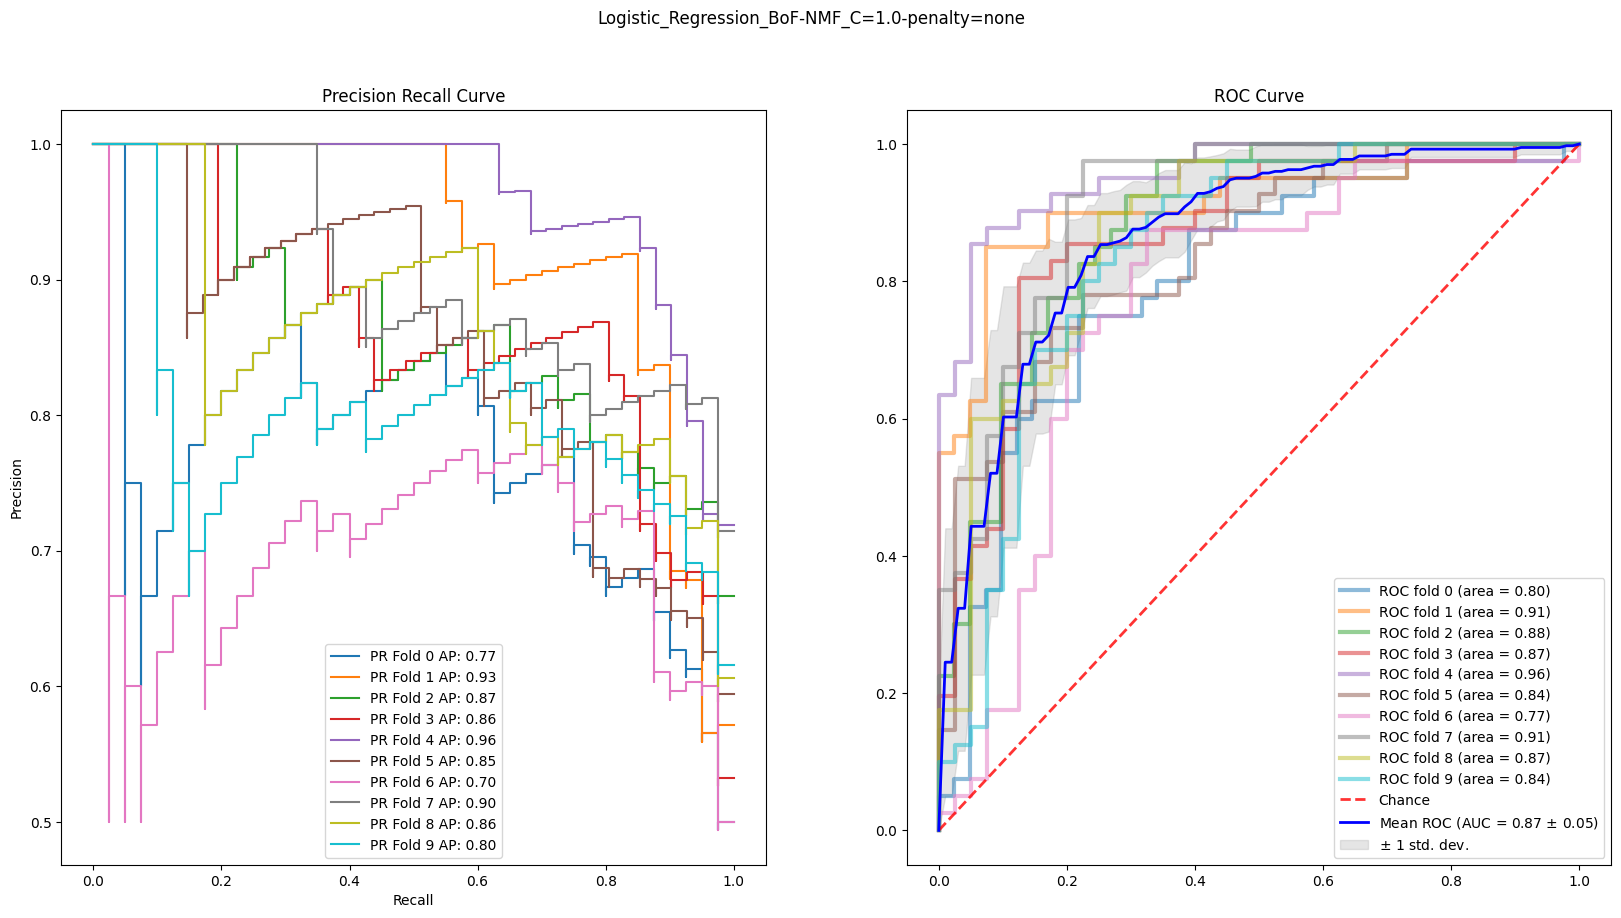

In [40]:
(precision_dict, recall_dict, f1_dict, auc_dict) = CV(model, X_dict, y, 
                                                      10, param_dict, 
                                                      param_title_dictionary, 
                                                      model_name, path)

In [41]:
results = [precision_dict, recall_dict, f1_dict, auc_dict]
df = storeresults(model, results, model_name, param_dict, 
                  param_title_dictionary, X, y, path)

df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

,Model,Dataset,Mean_Precision,STD_Precision,Mean_Recall,STD_Recall,Mean_F1,STD_F1,Mean_AUC,STD_AUC
1,Logistic_Regression_C=2.7825594022071245-penal...,Regular,0.735607,0.0540096,0.665427,0.073919,0.695663,0.0492565,0.781414,0.0382932
2,Logistic_Regression_C=1.0-penalty=none,PCA,0.758874,0.04706,0.603171,0.0754295,0.670174,0.0594637,0.765714,0.0325017
3,Logistic_Regression_C=1.0-penalty=l2,PCA80,0.782714,0.057111,0.734512,0.0755641,0.755823,0.0558723,0.847152,0.0483449
4,Logistic_Regression_C=1.0-penalty=l2,NMF,0.778421,0.0309563,0.749451,0.0750022,0.761837,0.0469839,0.842765,0.0341173
5,Logistic_Regression_C=3593.813663804626-penalt...,BoF,0.842403,0.0675518,0.821524,0.0552965,0.82993,0.0473998,0.906784,0.0330325
6,Logistic_Regression_C=1.0-penalty=none,BoF-PCA,0.834661,0.0650247,0.811524,0.0571244,0.820735,0.0440932,0.903146,0.0348523
7,Logistic_Regression_C=1.0-penalty=none,BoF-PCA80,0.810011,0.0551683,0.84378,0.0601572,0.824984,0.045519,0.880619,0.0494437
8,Logistic_Regression_C=1.0-penalty=none,BoF-NMF,0.796885,0.0478735,0.821402,0.0622301,0.807789,0.0462157,0.866337,0.0524545


# Storing Results

- Converts the dataframe into a csv file. 
- Creates a txt file that contains an experiment description. If the folder name is not sufficiently illustrating or there are important details to be compiled, they go there.

In [42]:
file_name = str(input('Enter the filename: '))
comment = str(input('Enter the experiment description:'))

df.to_csv(os.path.join(path,file_name + '.csv'))

np.savetxt(os.path.join(path,file_name + '.txt'),[comment], fmt = '%10s')

copytree(experiment,path,destination)

Enter the filename: Test_results
Enter the experiment description:Here go the number components or other relevant information of the experiments.
